In [ ]:
# Importamos los paquetes necesarios para la practica
import cv2  
import math 
from ultralytics import YOLO
import torch
import pytesseract
import csv
from PIL import Image
import torch 
from transformers import AutoProcessor, AutoModelForVision2Seq 
import numpy as np
import os


c:\Users\edani\anaconda3\envs\VC_P4B\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargamos el modelo ya entrenado para la deteccion de vehiculos y personas
model = YOLO("yolo11m.pt")

# Consultamos y mostramos el diccionario de clases
class_names = model.names
print(class_names)

# Ahora limitamos el modelo a detectar solo las clases de interes: vehiculos y personas
CLASES_DE_INTERES = [0, 2, 3, 5, 7]

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [ ]:
# Probamos el modelo con un video en el que aparecen coches y personas
filename = "prueba.mp4"
results = model(filename, show=True)

cv2.destroyAllWindows()
cv2.waitKey(0)

In [3]:
# Ahora importamos un modelo sin entrenar para poder entrenarlo y detectar matriculas
non_trained_model = YOLO("yolo11n.yaml")

# Antes de comenzar el entreno comprobamos que la GPU esta disponible
print(torch.cuda.is_available())

False


In [ ]:
# Entrenamos el modelo para la detección de matriculas

results = non_trained_model.train(
    data='LICENSE_PLATE_DETECTION.yaml',
    epochs=100,                          # Número de épocas
    imgsz=640,                           # Tamaño de la imagen de entrada
    batch=16,                            # Tamaño del lote
    patience=10,                        # Paciencia para la detención temprana
    device=0                            # Usar GPU 0 para el entrenamiento
)

In [3]:
# Si ya lo hemos entrenado previamente, podemos cargar los pesos guardados de la carpeta que elijamos
trained_model = YOLO("runs/detect/train8/weights/best.pt")

In [ ]:
# Evaluamos el modelo entrenado
results = trained_model.val(data="LICENSE_PLATE_DETECTION.yaml", imgsz=640)

# Imprimir métricas
print(results)

In [ ]:
results = trained_model("LicenseDetection.mp4", show=True)

cv2.destroyAllWindows()
cv2.waitKey(0)

In [19]:

# Ahora combinamos ambos modelos para detectar coches y matriculas en un video
video_path = 'prueba.mp4'
cap = cv2.VideoCapture(video_path)

# Colores para las detecciones
COLOR_COCHE = (255, 0, 0) # Azul
COLOR_MATRICULA = (0, 255, 0) # Verde

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detección de Coches
    results_cars = model(frame,
                           classes=CLASES_DE_INTERES, 
                           verbose=False)
    
    # Detección de Matrículas
    results_license = trained_model(frame, verbose=False)

    # Ahora combinamos las detecciones y dibujamos los cuadros en el frame
    
    # Dibujar coches
    for r in results_cars:
        for box in r.boxes:
            # Obtiene las coordenadas y las convierte a enteros
            x1, y1, x2, y2 = [int(i) for i in box.xyxy[0]]
            
            class_name = model.names[int(box.cls)]

            if class_name == "person":

                ROI = frame[y1:y2, x1:x2]
                if ROI.size != 0:
                    blurred = cv2.GaussianBlur(ROI, (23, 23), 30)
                    frame[y1:y2, x1:x2] = blurred

            # Obtenemos la confianza de la detección
            confidence = box.conf[0].item()
            label = f"{class_name} {confidence:.2f}"
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), COLOR_COCHE, 1)
            cv2.putText(frame, label, (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, COLOR_COCHE, 1)

    # Dibujar matrículas
    for r in results_license:
        for box in r.boxes:
            # Obtiene las coordenadas y las convierte a enteros
            x1, y1, x2, y2 = [int(i) for i in box.xyxy[0]]
            
            class_name = trained_model.names[int(box.cls)]

            confidence = box.conf[0].item()
            label = f"{class_name} {confidence:.2f}"

            # Extraemos la región de interés (ROI) para difuminarla
            ROI = frame[y1:y2, x1:x2]

            # Si la ROI no está vacía, aplicamos el difuminado
            if ROI.size != 0:
                blurred = cv2.GaussianBlur(ROI, (23, 23), 30)
                frame[y1:y2, x1:x2] = blurred
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), COLOR_MATRICULA, 1)
            cv2.putText(frame, label, (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, COLOR_MATRICULA, 1)


    # Mostrar el frame procesado
    cv2.imshow('Deteccion de Coches y Matriculas', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar recursos
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Se propone a continuacion una alternativa detectando matriculas mediante contornos

video_path = 'LicenseDetection.mp4'
cap = cv2.VideoCapture(video_path)

# Colores para las detecciones
COLOR_COCHE = (255, 0, 0) # Azul
COLOR_MATRICULA = (0, 255, 0) # Verde

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detección de Coches
    results_coches = model(frame,
                           classes=CLASES_DE_INTERES, 
                           verbose=False)

    # Ahora combinamos las detecciones y dibujamos los cuadros en el frame
    
    # Dibujar coches
    for r in results_coches:
        for box in r.boxes:
            # Obtiene las coordenadas y las convierte a enteros
            x1, y1, x2, y2 = [int(i) for i in box.xyxy[0]]
            
            class_name = model.names[int(box.cls)]

            if class_name == "person":

                ROI = frame[y1:y2, x1:x2]
                if ROI.size != 0:
                    difuminado = cv2.GaussianBlur(ROI, (23, 23), 30)
                    frame[y1:y2, x1:x2] = difuminado

            # Obtenemos la confianza de la detección
            confidence = box.conf[0].item()
            label = f"{class_name} {confidence:.2f}"
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), COLOR_COCHE, 1)
            cv2.putText(frame, label, (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, COLOR_COCHE, 1)
            
    for r in frame:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, edged = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)
            if 2 < aspect_ratio < 5 and 300 < cv2.contourArea(contour) < 500:
                ROI = frame[y:y+h, x:x+w]
                if ROI.size != 0:
                    difuminado = cv2.GaussianBlur(ROI, (23, 23), 30)
                    frame[y:y+h, x:x+w] = difuminado
                
                cv2.rectangle(frame, (x, y), (x + w, y + h), COLOR_MATRICULA, 1)
                cv2.putText(frame, "license_plate", (x, y - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, COLOR_MATRICULA, 1)
    
    # Mostrar el frame procesado
    cv2.imshow('Deteccion de Coches y Matriculas', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar recursos
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Configuración
device = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_CSV = "resultados_smol.csv"
CARPETA_IMAGENES = "OCR Detection"

# Cargar modelos
print("Cargando modelos...")
model_name = "HuggingFaceTB/SmolVLM-Instruct"
processor = AutoProcessor.from_pretrained(model_name)
model_lvm = AutoModelForVision2Seq.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
).to(device)

yolo_matricula = YOLO("runs/detect/train8/weights/best.pt")
print("Modelos cargados correctamente.\n")

# Función para reconocer texto usando SmolVLM
def reconocer_texto_matricula(img_crop):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": "Can you give me the text in the license plate of the image, without any spaces or extra explanation."}
            ]
        },
    ]
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[img_crop], return_tensors="pt").to(device)
    generated_ids = model_lvm.generate(**inputs, max_new_tokens=10)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    
    # Solo tomar la parte que realmente es la matrícula
    texto = generated_texts[0]
    
    # Limpiar prefijos o sufijos típicos (User:, Assistant:, saltos de línea, espacios)
    texto = texto.split("Assistant:")[-1].strip()
    texto = "".join([c for c in texto if c.isalnum()])
    return texto.upper()


# Obtener todos los archivos de imagen en la carpeta
imagenes = [
    os.path.join(CARPETA_IMAGENES, f)
    for f in os.listdir(CARPETA_IMAGENES)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Abrir CSV y escribir cabecera
with open(OUTPUT_CSV, mode='w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        "imagen", "tipo_objeto", "conf_objeto",
        "x1", "y1", "x2", "y2",
        "matricula_en_su_caso", "conf_matricula",
        "mx1", "my1", "mx2", "my2",
        "texto_matricula"
    ])

    # Procesar cada imagen
    for idx, img_path in enumerate(imagenes, 1):
        print(f"[{idx}/{len(imagenes)}] Procesando imagen: {img_path}...")
        img = Image.open(img_path).convert("RGB")
        
        # Detección de matrículas
        resultados_matricula = yolo_matricula.predict(img_path, verbose=False)[0]
        
        if len(resultados_matricula.boxes.data) == 0:
            print("  No se detectaron matrículas en esta imagen.")
            continue
        
        for det_idx, det in enumerate(resultados_matricula.boxes.data, 1):
            x1, y1, x2, y2, conf, cls = det.tolist()
            tipo_objeto = yolo_matricula.model.names[int(cls)]
            
            # Recortar la matrícula
            mx1, my1, mx2, my2 = map(int, [x1, y1, x2, y2])
            img_crop = img.crop((mx1, my1, mx2, my2))
            
            print(f"  [{det_idx}/{len(resultados_matricula.boxes.data)}] Detectada matrícula, reconociendo texto...")
            # Reconocer texto
            texto_matricula = reconocer_texto_matricula(img_crop)
            print(f"    Texto reconocido: {texto_matricula}")
            
            # Escribir fila en CSV
            writer.writerow([
                os.path.basename(img_path),
                tipo_objeto, conf,
                x1, y1, x2, y2,
                texto_matricula,
                conf,
                mx1, my1, mx2, my2,
                texto_matricula if texto_matricula != "" else ""
            ])

print(f"\nProcesamiento completado. Resultados guardados en {OUTPUT_CSV}")

Cargando modelos...


c:\Users\edani\anaconda3\envs\VC_P4B\lib\site-packages\transformers\models\auto\modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Modelos cargados correctamente.

[1/100] Procesando imagen: OCR Detection\00000.jpg...
  [1/1] Detectada matrícula, reconociendo texto...
    Texto reconocido: 597LK
[2/100] Procesando imagen: OCR Detection\00014.jpg...
  [1/1] Detectada matrícula, reconociendo texto...
    Texto reconocido: 076YR
[3/100] Procesando imagen: OCR Detection\00015.jpg...
  No se detectaron matrículas en esta imagen.
[4/100] Procesando imagen: OCR Detection\00016.jpg...
  No se detectaron matrículas en esta imagen.
[5/100] Procesando imagen: OCR Detection\00022.jpg...
  No se detectaron matrículas en esta imagen.
[6/100] Procesando imagen: OCR Detection\00024.jpg...
  [1/2] Detectada matrícula, reconociendo texto...
    Texto reconocido: 051DH
  [2/2] Detectada matrícula, reconociendo texto...
    Texto reconocido: 123456
[7/100] Procesando imagen: OCR Detection\00035.jpg...
  [1/2] Detectada matrícula, reconociendo texto...
    Texto reconocido: 727PP
  [2/2] Detectada matrícula, reconociendo texto...
    

In [5]:
# Configuración
device = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_CSV = "resultados_tesseract.csv"
CARPETA_IMAGENES = "OCR Detection"

# Ruta a Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

# Cargar modelo YOLO para matrículas
print("Cargando modelo YOLO de matrículas...")
yolo_matricula = YOLO("runs/detect/train8/weights/best.pt")
print("Modelo cargado correctamente.\n")

# Función para reconocer texto usando Tesseract
def reconocer_texto_matricula(img_crop):
    # Convertir a gris y aplicar umbral para mejorar OCR
    img_gray = img_crop.convert("L")
    texto = pytesseract.image_to_string(img_gray, config='--psm 8 --oem 3')
    # Limpiar saltos de línea y espacios
    return texto.strip()

# Obtener todos los archivos de imagen en la carpeta
imagenes = [
    os.path.join(CARPETA_IMAGENES, f)
    for f in os.listdir(CARPETA_IMAGENES)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Abrir CSV y escribir cabecera
with open(OUTPUT_CSV, mode='w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        "imagen", "tipo_objeto", "conf_objeto",
        "x1", "y1", "x2", "y2",
        "matricula_en_su_caso", "conf_matricula",
        "mx1", "my1", "mx2", "my2",
        "texto_matricula"
    ])

    # Procesar cada imagen
    for idx, img_path in enumerate(imagenes, 1):
        print(f"[{idx}/{len(imagenes)}] Procesando imagen: {img_path}...")
        img = Image.open(img_path).convert("RGB")
        
        # Detección de matrículas
        resultados_matricula = yolo_matricula.predict(img_path, verbose=False)[0]
        
        if len(resultados_matricula.boxes.data) == 0:
            print("  No se detectaron matrículas en esta imagen.")
            continue
        
        for det_idx, det in enumerate(resultados_matricula.boxes.data, 1):
            x1, y1, x2, y2, conf, cls = det.tolist()
            tipo_objeto = yolo_matricula.model.names[int(cls)]
            
            # Recortar la matrícula
            mx1, my1, mx2, my2 = map(int, [x1, y1, x2, y2])
            img_crop = img.crop((mx1, my1, mx2, my2))
            
            print(f"  [{det_idx}/{len(resultados_matricula.boxes.data)}] Detectada matrícula, reconociendo texto...")
            # Reconocer texto con Tesseract
            texto_matricula = reconocer_texto_matricula(img_crop)
            print(f"    Texto reconocido: {texto_matricula}")
            
            # Escribir fila en CSV
            writer.writerow([
                os.path.basename(img_path),
                tipo_objeto, conf,
                x1, y1, x2, y2,
                texto_matricula,
                conf,
                mx1, my1, mx2, my2,
                texto_matricula if texto_matricula != "" else ""
            ])

print(f"\nProcesamiento completado. Resultados guardados en {OUTPUT_CSV}")

Cargando modelo YOLO de matrículas...
Modelo cargado correctamente.

[1/100] Procesando imagen: OCR Detection\00000.jpg...
  [1/1] Detectada matrícula, reconociendo texto...
    Texto reconocido: pean
[2/100] Procesando imagen: OCR Detection\00014.jpg...
  [1/1] Detectada matrícula, reconociendo texto...
    Texto reconocido: S0756 BYR]
[3/100] Procesando imagen: OCR Detection\00015.jpg...
  No se detectaron matrículas en esta imagen.
[4/100] Procesando imagen: OCR Detection\00016.jpg...
  No se detectaron matrículas en esta imagen.
[5/100] Procesando imagen: OCR Detection\00022.jpg...
  No se detectaron matrículas en esta imagen.
[6/100] Procesando imagen: OCR Detection\00024.jpg...
  [1/2] Detectada matrícula, reconociendo texto...
    Texto reconocido: Ose 1 DH |
  [2/2] Detectada matrícula, reconociendo texto...
    Texto reconocido: =
[7/100] Procesando imagen: OCR Detection\00035.jpg...
  [1/2] Detectada matrícula, reconociendo texto...
    Texto reconocido: 172.7 PP
  [2/2] Dete

Tasa de acierto SmolVLM: 50.00% (50/100)
Tasa de acierto Tesseract: 2.00% (2/100)


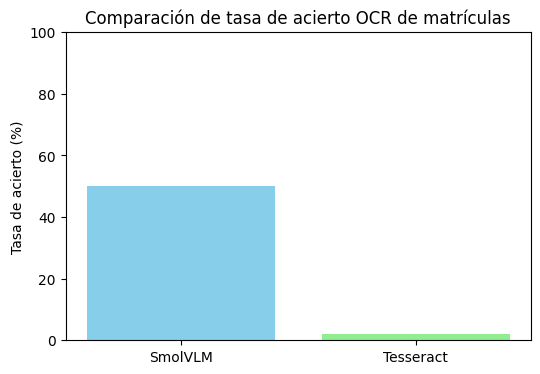

In [ ]:
import os
import json
import csv
import matplotlib.pyplot as plt

# Carpeta de imágenes y JSON
CARPETA_OCR = "OCR Detection"

# Archivos CSV
csv_smol = "resultados_smol.csv"
csv_tesseract = "resultados_tesseract.csv"

# Función para leer CSV y obtener última columna (texto_matricula) por imagen
def leer_csv(csv_file, unir_caracteres=False):
    resultados = {}
    with open(csv_file, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            imagen = row["imagen"]
            texto_detectado = row[list(row.keys())[-1]].strip().upper() 
            if unir_caracteres:
                # Eliminar caracteres no alfanuméricos
                texto_detectado = "".join([c for c in texto_detectado if c.isalnum()])
            resultados[imagen] = texto_detectado
    return resultados

# Función para extraer matrícula de JSON
def extraer_matricula_json(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    lps = data.get("lps", [])
    if not lps:
        return ""
    # Tomamos la primera matrícula si hay varias
    lp = lps[0]
    # Unir caracteres alfanuméricos
    chars = [c["char_id"] for c in lp.get("characters", []) if c["char_id"].isalnum()]
    return "".join(chars).upper()

# Leer CSV
resultados_smol = leer_csv(csv_smol)
resultados_tesseract = leer_csv(csv_tesseract, unir_caracteres=True)

# Leer JSON y comparar
imagenes_json = [f for f in os.listdir(CARPETA_OCR) if f.lower().endswith(".json")]

aciertos_smol = 0
aciertos_tesseract = 0
total = 0

for json_file in imagenes_json:
    imagen_name = json_file.replace(".json", ".jpg")
    total += 1
    matricula_correcta = extraer_matricula_json(os.path.join(CARPETA_OCR, json_file))
    
    # Comparar con SmolVLM
    if imagen_name in resultados_smol and resultados_smol[imagen_name] == matricula_correcta:
        aciertos_smol += 1
    
    # Comparar con Tesseract
    if imagen_name in resultados_tesseract and resultados_tesseract[imagen_name] == matricula_correcta:
        aciertos_tesseract += 1

# Calcular tasas de acierto
tasa_smol = aciertos_smol / total * 100
tasa_tesseract = aciertos_tesseract / total * 100

print(f"Tasa de acierto SmolVLM: {tasa_smol:.2f}% ({aciertos_smol}/{total})")
print(f"Tasa de acierto Tesseract: {tasa_tesseract:.2f}% ({aciertos_tesseract}/{total})")

# Graficar tasa de acierto
metodos = ["SmolVLM", "Tesseract"]
tasa_aciertos = [tasa_smol, tasa_tesseract]

plt.figure(figsize=(6,4))
plt.bar(metodos, tasa_aciertos, color=["skyblue", "lightgreen"])
plt.ylabel("Tasa de acierto (%)")
plt.title("Comparación de tasa de acierto OCR de matrículas")
plt.ylim(0, 100)
plt.show()
